In [2]:
import numpy as np
import pandas as pd
import glob
import subprocess

from scipy.fftpack import fft
from scipy.signal import welch
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
files = glob.glob('80141858*.dat')
distinct_files = set()
for file in files:
    distinct_files.add(file.split('_')[0])
print(distinct_files)
df_list = [pd.read_table(file, header=None, names=['Segment', '%s' % file.split('.')[0]], index_col=0) for file in files]
big_df = pd.concat(df_list, axis=1)

{'80141858'}


In [4]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_cor_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values


In [43]:
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.5"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

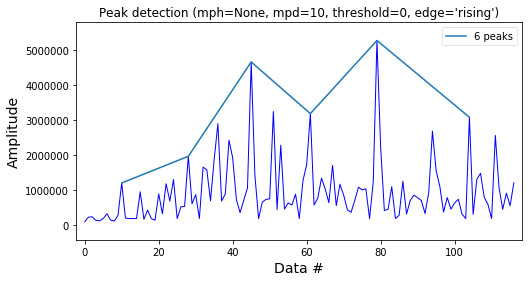

[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0]]
10000


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))


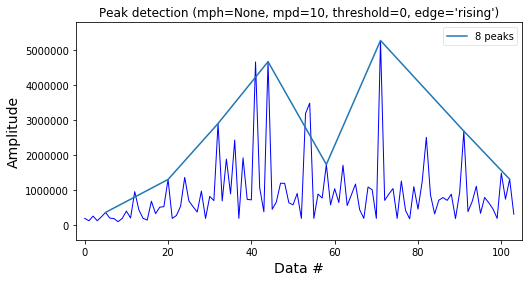

[241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0]]
10005


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


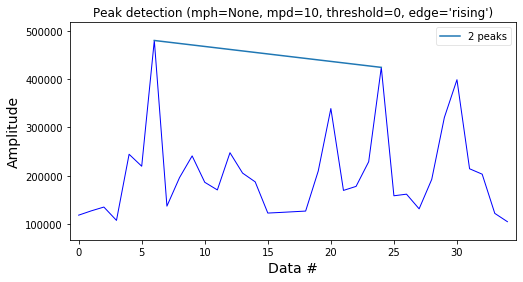

[219617.0, 228951.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0]]
1200


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 35, using nperseg = 35
  .format(nperseg, input_length))


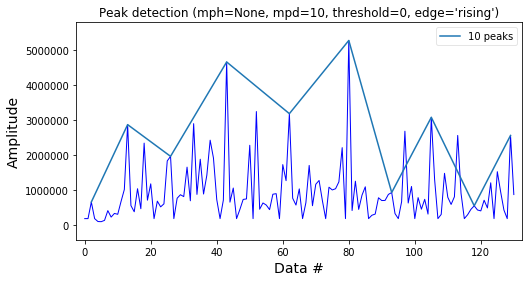

[196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0]]
15000


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 131, using nperseg = 131
  .format(nperseg, input_length))


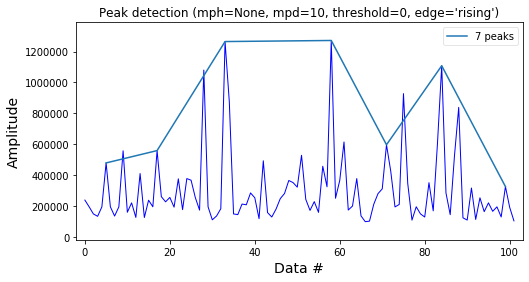

[195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0]]
2000


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 102, using nperseg = 102
  .format(nperseg, input_length))


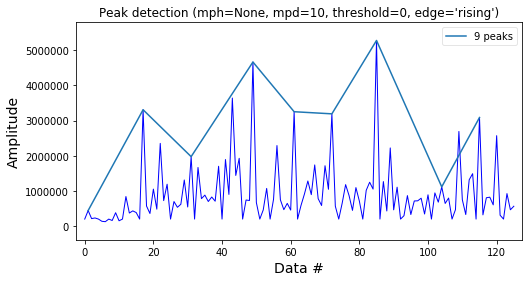

[196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0]]
20000


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 126, using nperseg = 126
  .format(nperseg, input_length))


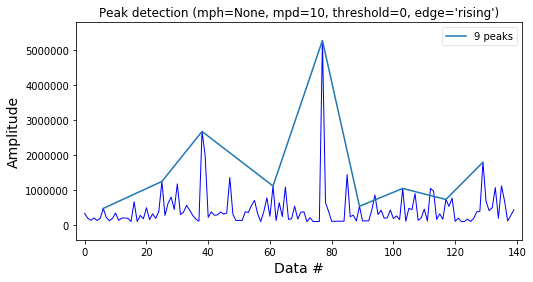

[195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0]]
3500


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 140, using nperseg = 140
  .format(nperseg, input_length))


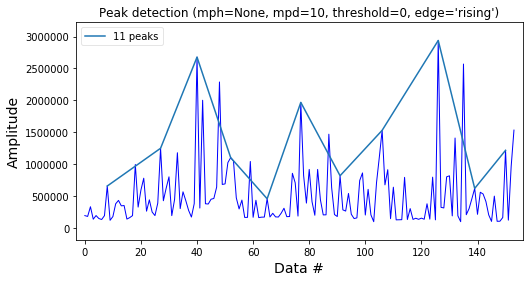

[195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0]]
4200


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 154, using nperseg = 154
  .format(nperseg, input_length))


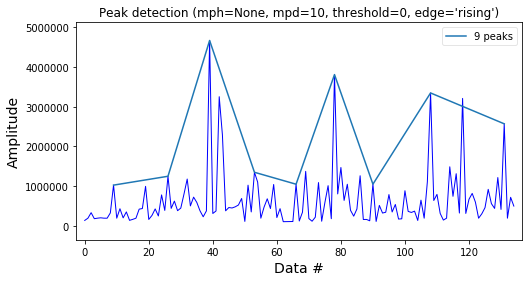

[328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0]]
4800


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 135, using nperseg = 135
  .format(nperseg, input_length))


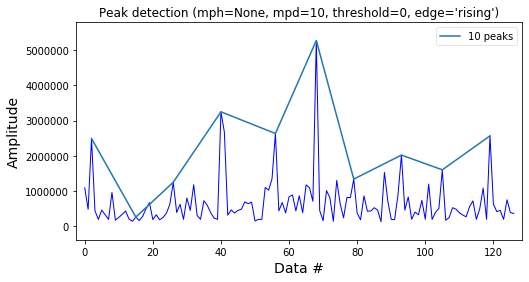

[480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0]]
4900


/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 127, using nperseg = 127
  .format(nperseg, input_length))


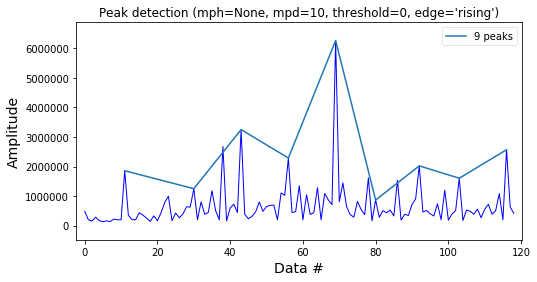

[196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 160537.0, 902832.0, 506201.0, 196570.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 160537.0, 902

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))


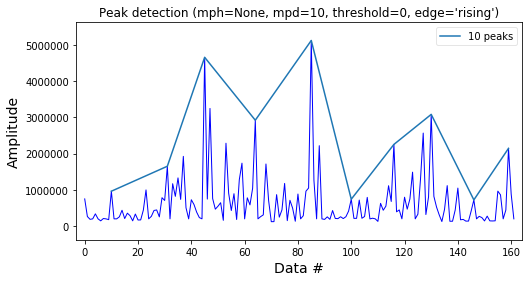

[174519.0, 704974.0, 196567.0, 1043724.0, 1048885.0, 411136.0, 677394.0, 803103.0, 416778.0, 441205.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 16

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 162, using nperseg = 162
  .format(nperseg, input_length))


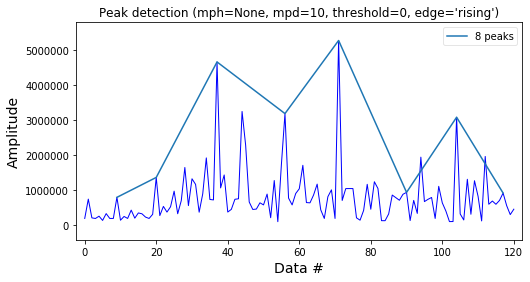

[196407.0, 314652.0, 725378.0, 1736806.0, 196052.0, 886705.0, 108416.0, 711937.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 160537.0, 902832.0, 506

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  .format(nperseg, input_length))


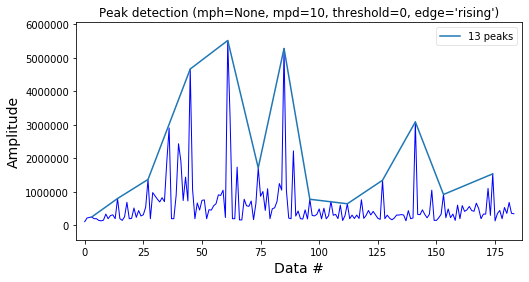

[234925, 196410, 540314, 725375, 231762, 649430, 1048884, 188672, 288877, 176941, 218663, 331770, 295547]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0,

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 184, using nperseg = 184
  .format(nperseg, input_length))


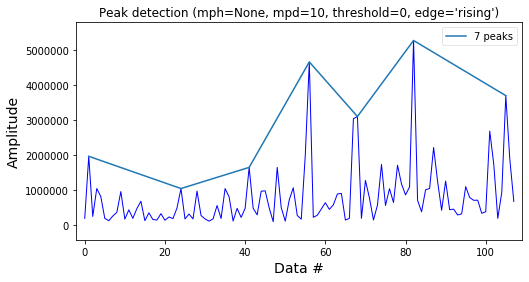

[196052.0, 489274.0, 483135.0, 2001974.0, 3042301.0, 1091866.0, 940781.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 160537.0, 902832.0, 506201.0, 1

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  .format(nperseg, input_length))


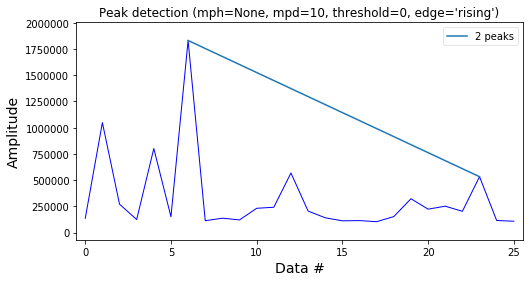

[150503.0, 202246.0]
[[291595.0, 540314.0, 1068552.0, 1736808.0, 1244545.0, 196645.0], [241564.0, 531509.0, 704974.0, 383667.0, 778005.0, 196052.0, 940785.0, 746269.0], [219617.0, 228951.0], [196568.0, 1026412.0, 1841317.0, 725378.0, 1279300.0, 196755.0, 886704.0, 325423.0, 460767.0, 196249.0], [195753.0, 196514.0, 184319.0, 325821.0, 312277.0, 605734.0, 130944.0], [196514.0, 196106.0, 540315.0, 725377.0, 452592.0, 1043725.0, 1048884.0, 677395.0, 195971.0], [195755.0, 391719.0, 117147.0, 253712.0, 105600.0, 121213.0, 160512.0, 170368.0, 399067.0], [195755.0, 391721.0, 383666.0, 1026408.0, 173184.0, 188816.0, 181994.0, 1112927.0, 129443.0, 460766.0, 166137.0], [328919.0, 391718.0, 379442.0, 353803.0, 112640.0, 183381.0, 131012.0, 1112927.0, 416778.0], [480799.0, 141893.0, 625667.0, 196567.0, 1350504.0, 709878.0, 812496.0, 902830.0, 506203.0, 196568.0], [196408.0, 625793.0, 442693.0, 1026409.0, 709880.0, 160537.0, 902832.0, 506201.0, 196570.0], [174519.0, 704974.0, 196567.0, 1043724.0, 1

/home/peveloper/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  .format(nperseg, input_length))


In [44]:
features = 15
data = np.zeros((len(big_df.columns), (features * 2) + 1))

i=0
k=0

peak_list = []
for file in sorted(big_df.columns):
    id = file.split('_')[0]
    tp = file.split('_')[-1]
    
    column = big_df[file].dropna()
    
    peak_idxs = detect_peaks(column, show=True, mpd=10)
    peaks = [column[i] for i in peak_idxs]
    print(peaks)
    peak_list.append(peaks)
    print(peak_list)
    print(tp)
    t_n = 0.1
    N = column.shape[0]
    T = t_n / N
    f_s = 1 / T  
    
    x, y = get_fft_values(column, T, N, f_s)
    idxs = detect_peaks(y)[:5]

    for z, el in enumerate(idxs):
        x[z] = x[el]
        y[z] = y[el]
        data[i][z + k] = x[z]
        data[i][z + k + 1] = y[z]
        k+=1

    k+=z+1
    x, y = get_psd_values(column, T, N, f_s)
    idxs = detect_peaks(y)[:5]

    for z, el in enumerate(idxs):
        x[z] = x[el]
        y[z] = y[el]
        data[i][z + k] = x[z]
        data[i][z + k + 1] = y[z]
        k+=1
        
    k+=z+1
    x, y = get_cor_values(column, T, N, f_s)
    idxs = detect_peaks(y)[:5]

    for z, el in enumerate(idxs):
        x[z] = x[el]
        y[z] = y[el]
        data[i][z + k] = x[z]
        data[i][z + k + 1] = y[z]
        k+=1
        
    k+=z+1
    data[i][k] = int(file)
        
    i+=1
    k=0
    


In [37]:
data[0]

array([5.13157895e+01, 1.03936311e+05, 8.21052632e+01, 2.40057301e+05,
       1.02631579e+02, 1.31308608e+05, 1.43684211e+02, 2.79317645e+05,
       1.64210526e+02, 1.98879747e+05, 1.00000000e+01, 3.15071855e+09,
       3.00000000e+01, 1.11780162e+09, 8.00000000e+01, 3.44434018e+09,
       1.40000000e+02, 5.03369780e+09, 1.70000000e+02, 4.22421711e+09,
       3.41880342e-03, 1.12330491e+14, 5.12820513e-03, 1.16263397e+14,
       6.83760684e-03, 1.10731257e+14, 8.54700855e-03, 1.15077944e+14,
       1.02564103e-02, 1.09861826e+14, 8.01418581e+12])

In [8]:
X_train = data[:, :-1]
Y_train = data[:, -1]

In [9]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))

Accuracy on training set is : 0.9951456310679612
